In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks import *

In [3]:
torch.cuda.is_available()

True

In [4]:
np.random.seed(42)

In [5]:
tfms = get_transforms(do_flip=True,flip_vert=False,max_rotate=10.0,max_zoom=1.2,max_lighting=0.5,max_warp=0.2,p_affine=0.75,p_lighting=0.75)


In [6]:
mixup=0.2

In [7]:
# loss_func = LabelSmoothingCrossEntropy()

In [8]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=1.):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, **kwargs):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
        return F_loss.mean()
loss_func = FocalLoss(gamma=2.5)

In [9]:
alpha=0.99
mom=0.9
eps=1e-6

In [10]:
opt_func = partial(optim.Adam, betas=(mom,alpha), eps=eps)

In [11]:
src = (ImageList.from_folder(path='train').split_by_rand_pct(0.2).label_from_folder())

In [12]:
data = src.transform(tfms,size=(640)).databunch(bs=24).normalize()

In [13]:
learn = cnn_learner(data, models.densenet121,pretrained=False, metrics=[error_rate, accuracy, FBeta(beta=1,average='macro')],loss_func = loss_func,opt_func=opt_func,wd=1e-2)

/home/ubuntu/anaconda3/envs/snakes_breed/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [14]:
learn= learn.mixup(alpha=mixup)

In [15]:
learn.bn_wd=False

In [16]:
learn.true_wd=True

In [17]:
learn.load('exp-12-round-1')

/home/ubuntu/anaconda3/envs/snakes_breed/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type FocalLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Learner(data=ImageDataBunch;

Train: LabelList (65934 items)
x: ImageList
Image (3, 640, 640),Image (3, 640, 640),Image (3, 640, 640),Image (3, 640, 640),Image (3, 640, 640)
y: CategoryList
class-857,class-857,class-857,class-857,class-857
Path: train;

Valid: LabelList (16483 items)
x: ImageList
Image (3, 640, 640),Image (3, 640, 640),Image (3, 640, 640),Image (3, 640, 640),Image (3, 640, 640)
y: CategoryList
class-540,class-526,class-771,class-4,class-804
Path: train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [18]:
data_768 = src.transform(tfms,size=(768)).databunch(bs=18).normalize()

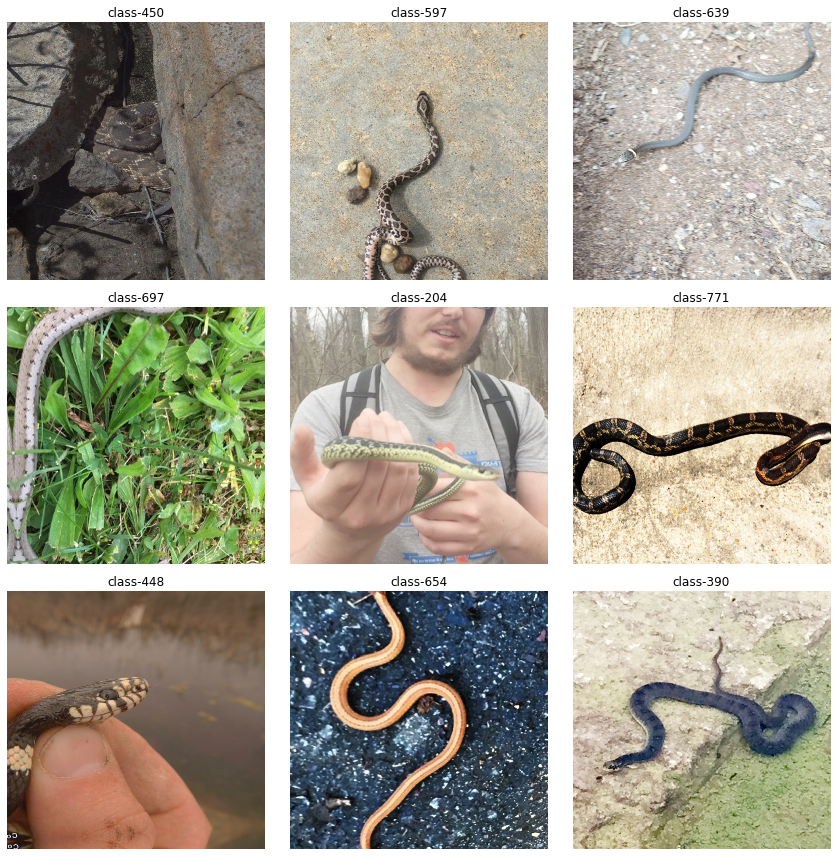

In [19]:
data_768.show_batch(rows=3, figsize=(12,12))

In [20]:
learn.data= data_768

In [21]:
learn = learn.to_fp16(dynamic=True)

In [22]:
learn.unfreeze()

In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


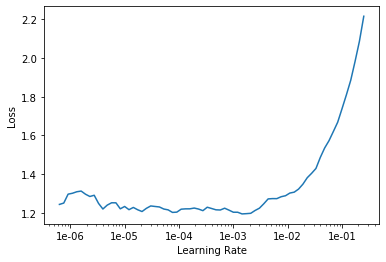

In [24]:
learn.recorder.plot()

In [25]:
lr=5e-5

In [26]:
learn.fit_one_cycle(10, lr, div_factor=10, pct_start=0.3)

epoch,train_loss,valid_loss,error_rate,accuracy,f_beta,time
0,1.141913,0.585780,0.224049,0.775951,0.737116,34:47
1,1.141529,0.575410,0.224110,0.775890,0.734777,34:31
2,1.115581,0.572895,0.224474,0.775526,0.734551,34:34
3,1.087074,0.574729,0.221744,0.778256,0.736864,34:33
4,1.128035,0.567798,0.223564,0.776436,0.737679,34:34
5,1.121259,0.559689,0.220348,0.779652,0.743089,34:35
6,1.123124,0.560032,0.222472,0.777528,0.738596,34:30
7,1.126204,0.554892,0.219560,0.780440,0.740386,34:34
8,1.099912,0.559922,0.220894,0.779106,0.740485,34:36


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [27]:
learn.save('exp-13-round-1')

In [28]:
learn

Learner(data=ImageDataBunch;

Train: LabelList (65934 items)
x: ImageList
Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768)
y: CategoryList
class-857,class-857,class-857,class-857,class-857
Path: train;

Valid: LabelList (16483 items)
x: ImageList
Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768)
y: CategoryList
class-540,class-526,class-771,class-4,class-804
Path: train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [29]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


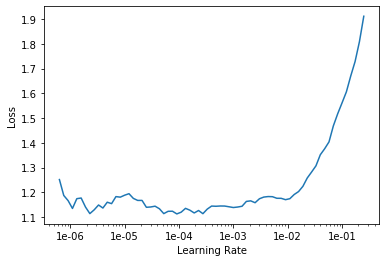

In [30]:
learn.recorder.plot()

In [33]:
lr = 1e-5